In [1]:
import numpy as np
import pandas as pd

from scalp_utils import *
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
plt.style.use('dark_background')
pd.options.display.precision = 10

In [2]:
y_AH_dict = joblib.load('results/y_AH_dict_16.pkl')
eog1_dict = joblib.load('results/eog1_dict_before_split.pkl')
eog2_dict = joblib.load('results/eog2_dict_before_split.pkl')
avg_dict = joblib.load('results/avg_dict_before_split.pkl')

In [46]:
params = {
    'learning_rate': 0.15,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 70,  # 2^max_depth - 1
    'max_depth': 7,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99 # because training data is extremely unbalanced
}

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'average_precision', # TODO: try precision?
    'learning_rate': 0.01,
    #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
    'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 255,  # Number of bucketed bin for feature values
    'subsample': 0.6,  # Subsample ratio of the training instance.
    'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 4,
    'verbose': 0,
}

lgb_params.update(params)

In [52]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True


In [30]:
# try only good subj
# all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x not in subj_bad])
for subj in all_subject:
    if subj not in subj_bad:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

In [3]:
# all 16
# all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    if subj in subj_eog1:
        curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    elif subj in subj_eog2:
        curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    else:
        curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

In [8]:
# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

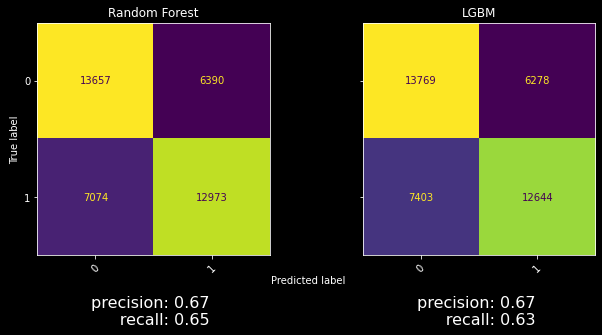

In [10]:
# cls, pred_details = plot_results(X_train, X_test, y_train, y_test)
x_train, x_test, y_train, y_test, prob = X_train_after, X_test_after, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = x_test[x_train_data.columns]
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=1200,
                                             min_samples_split=10,
                                             min_samples_leaf=2,
                                             max_features='auto',
                                             max_depth=None,
                                             bootstrap=False),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 16 artists>

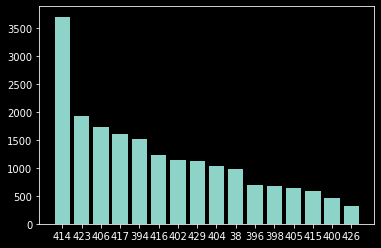

In [12]:
details = pred_details['Random Forest']
data = details[(details['pred'] >= 0.5)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

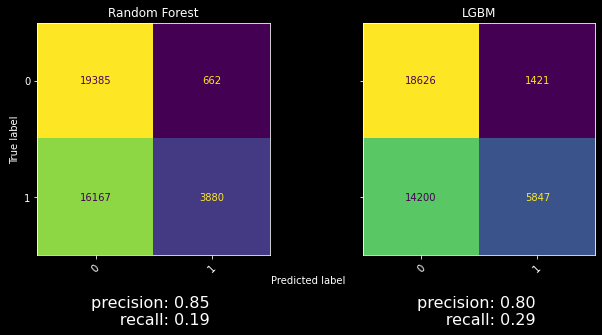

In [13]:
prob = 0.7
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 16 artists>

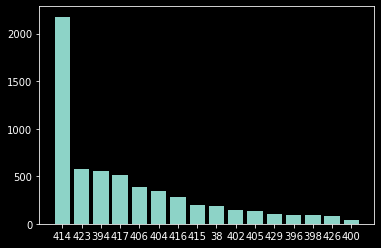

In [144]:
details = pred_details['Random Forest']
data = details[(details['pred'] >= 0.7)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[10]	train's average_precision: 0.134763	train's f1: 0.0985767	test's average_precision: 0.132015	test's f1: 0.0982782
[20]	train's average_precision: 0.145283	train's f1: 0.0964721	test's average_precision: 0.140692	test's f1: 0.0961149
[30]	train's average_precision: 0.154438	train's f1: 0.0969643	test's average_precision: 0.146605	test's f1: 0.096516
[40]	train's average_precision: 0.161366	train's f1: 0.0977759	test's average_precision: 0.150152	test's f1: 0.0972054
[50]	train's average_precision: 0.165488	train's f1: 0.0986011	test's average_precision: 0.152275	test's f1: 0.097834
[60]	train's average_precision: 0.168735	train's f1: 0.0994941	test's average_precision: 0.153664	test's f1: 0.0984681
[70]	train's average_precision: 0.172449	train's f1: 0.100244	test's average_precision: 0.15462	test's f1: 0.09897
[80]	tra

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='f1'>

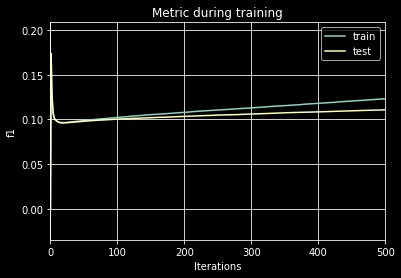

In [53]:
import lightgbm as lgb
# clf = lgb.train(param, train_data, valid_sets=[val_data, train_data], valid_names=['val', 'train'], feval=lgb_f1_score, evals_result=evals_result)
#
# lgb.plot_metric(evals_result, metric='f1')

evals_results = {}
train_dataset = lgb.Dataset(x_train_data, label=y_train)
test_dataset = lgb.Dataset(x_test_data, label=y_test)
bst1 = lgb.train(lgb_params,
                 train_dataset,
                 valid_sets=[train_dataset, test_dataset],
                 valid_names=['train','test'],
                 evals_result=evals_results,
                 num_boost_round=500,
                 feval=lgb_f1_score,
                 # early_stopping_rounds=30,
                 verbose_eval=10)

n_estimators = bst1.best_iteration
print("\nModel Report")
print("n_estimators : ", n_estimators)
# print('map'+":", evals_results['test']['average_precision'][n_estimators-1])
lgb.plot_metric(evals_results, metric='f1')

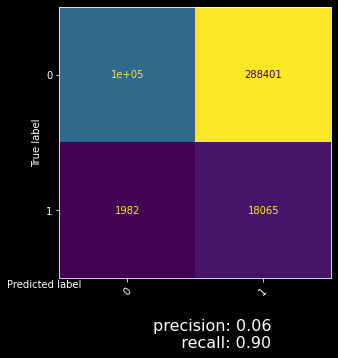

In [54]:
prob = 0.5
f, axes = plt.subplots(1, 1, figsize=(10, 5), sharey='row')
y_pred = bst1.predict(x_test_data)
cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred])
metrics = get_metrics(cf_matrix)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot(ax=axes, xticks_rotation=45)
precision = '{0:.2f}'.format(metrics['precision'])
recall = '{0:.2f}'.format(metrics['recall'])
text = """precision: {0}
                  recall: {1}""".format(precision, recall)
axes.annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                 xytext=(-60, -40), textcoords='offset points',
                 ha='right', va='top')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')
curr_pred_details = pd.DataFrame(data=x_test, copy=True)
curr_pred_details['pred'] = y_pred
f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [201]:
# generalization
# all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
out_subj = '38'
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x != out_subj])
for subj in all_subject:
    if subj != out_subj:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])


In [120]:
# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()) * 5)
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

x_train, x_test, y_train, y_test, prob = X_train, X_test, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = x_test[x_train_data.columns]

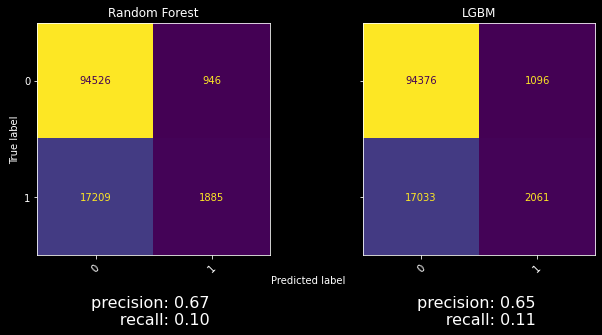

In [121]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

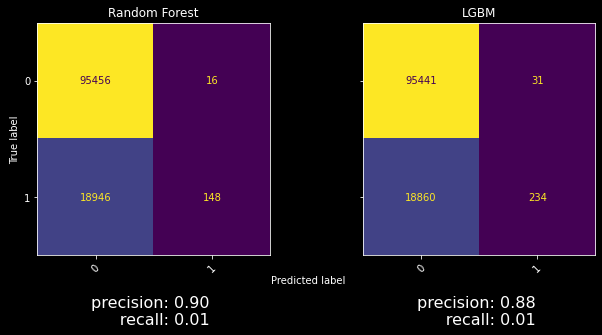

In [122]:
prob = 0.8
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

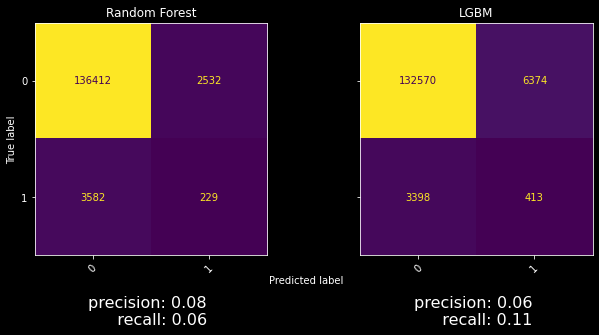

In [123]:
# out subject
y_out = y_AH_dict[out_subj]
if out_subj in subj_eog1:
    feat_out = pd.concat([eog1_dict[out_subj], avg_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
elif out_subj in subj_eog2:
    feat_out = pd.concat([eog2_dict[out_subj], avg_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
else:
    feat_out = pd.concat([eog1_dict[out_subj], eog2_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)

# Add norm values
feat_out = calc_features_after_split(feat_out)
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

feat_out_data = feat_out.iloc[:, 2:]
feat_out_data = feat_out_data[classifiers['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(feat_out_data)
    cf_matrix = confusion_matrix(y_out, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

C:\repos\spikes_notebooks\depth_utils.py:80: RuntimeWarning: invalid value encountered in double_scalars
  f_score = 1.25 * numerator / denominator


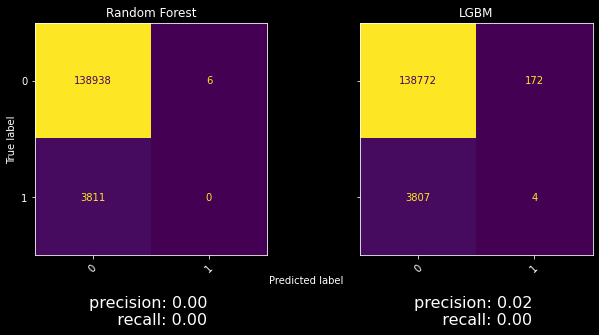

In [125]:
prob = 0.80
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict_proba(feat_out_data).T
    cf_matrix = confusion_matrix(y_out, [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

### Only good subjects ###

In [240]:
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x not in subj_bad])
for subj in all_subject:
    if subj not in subj_bad:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

In [241]:
# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)
X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

x_train, x_test, y_train, y_test, prob = X_train_after, X_test_after, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = x_test[x_train_data.columns]

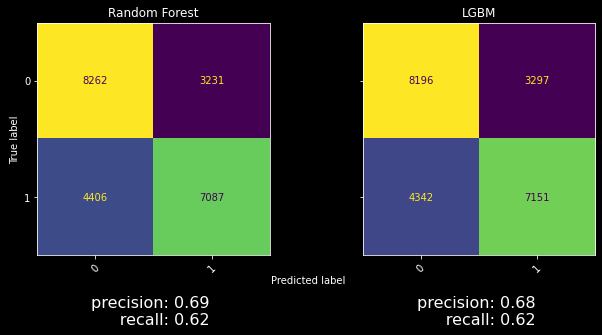

In [242]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [250]:
feature_names = pd.DataFrame(classifiers['LGBM'].feature_name_)
feature_names['imp'] = classifiers['Random Forest'].feature_importances_
feature_imp = feature_names.sort_values(by=['imp'], ascending=False)
feature_imp.head(10)

,0,imp
42,ft_cmin_norm,0.0233848674
26,std_cmin_norm,0.0230287207
56,fast_2_cmin_norm,0.0211984683
35,fast_cmin_norm,0.0201545676
60,bf_2_cmin_norm,0.0201015103
47,std_2_cmin_norm,0.0197177777
44,abspow_cmin_norm,0.0195825022
12,std_2,0.0189888490
61,gf_2_cmin_norm,0.0184810052
27,iqr_cmin_norm,0.0178653904


In [255]:
feature_names = pd.DataFrame(classifiers['LGBM'].feature_name_)
feature_names['imp'] = classifiers['LGBM'].feature_importances_
feature_imp = feature_names.sort_values(by=['imp'], ascending=False)
feature_imp.head(10)

,0,imp
12,std_2,135
44,abspow_cmin_norm,104
26,std_cmin_norm,100
22,gf_2,100
25,abspow_2,99
4,hcomp,97
51,hmob_2_cmin_norm,95
21,bf_2,91
30,hmob_cmin_norm,87
1,skew,84


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

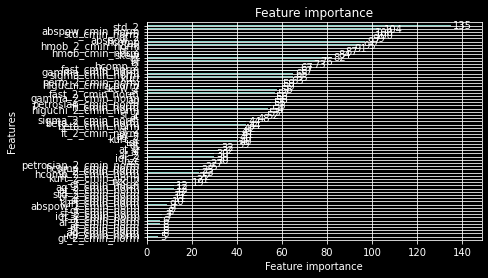

In [254]:
import lightgbm
lightgbm.plot_importance(classifiers['LGBM'])

<BarContainer object of 8 artists>

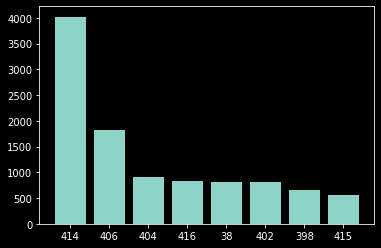

In [243]:
details = pred_details['LGBM']
data = details[(details['pred'] >= 0.7)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

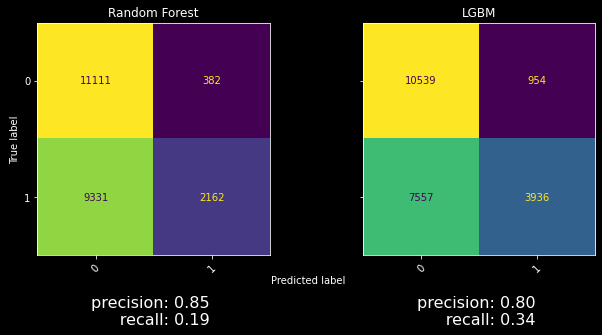

In [244]:
prob = 0.7
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

### Stratify by subj ###

In [256]:
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    if subj in subj_eog1:
        curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    elif subj in subj_eog2:
        curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    else:
        curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)


X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

x_train, x_test, y_train, y_test, prob = X_train_after, X_test_after, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = x_test[x_train_data.columns]

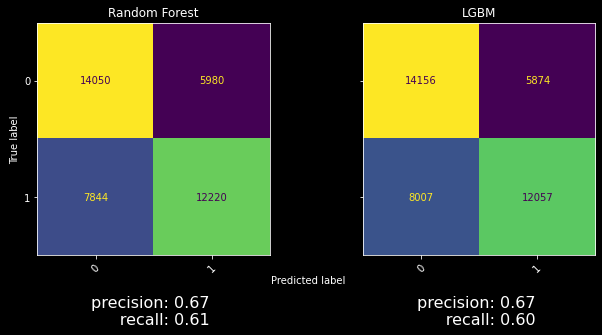

In [257]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 16 artists>

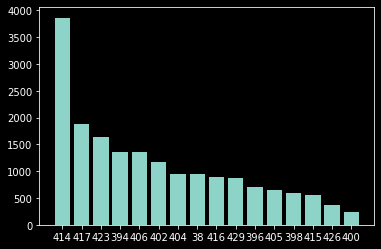

In [158]:
details = pred_details['LGBM']
data = details[(details['pred'] > 0.5)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

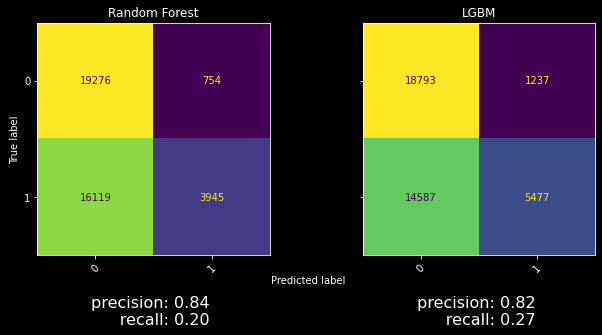

In [258]:
prob = 0.7
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 14 artists>

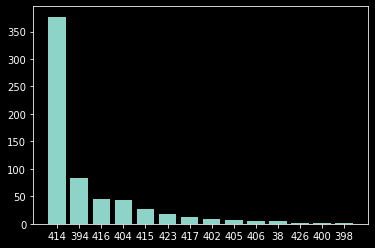

In [165]:
details = pred_details['LGBM']
data = details[(details['pred'] > 0.9)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

### same features

In [263]:
# EOG 1+2
feat_all_good = pd.DataFrame()
out_subj = '38'
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x != out_subj])
for subj in all_subject:
    if subj != out_subj:
        curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()) * 5)
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)


X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

# out subject
out_subj = '38'
y_out = y_AH_dict[out_subj]
feat_out = pd.concat([eog1_dict[out_subj], eog2_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
feat_out = calc_features_after_split(feat_out)

# X_train = pd.concat([X_train, feat_out.iloc[:10, :]])
# y_train = np.concatenate((y_train, np.zeros(10)))
x_train, x_test, y_train, y_test, prob = X_train_after, X_test_after, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = x_test[x_train_data.columns]

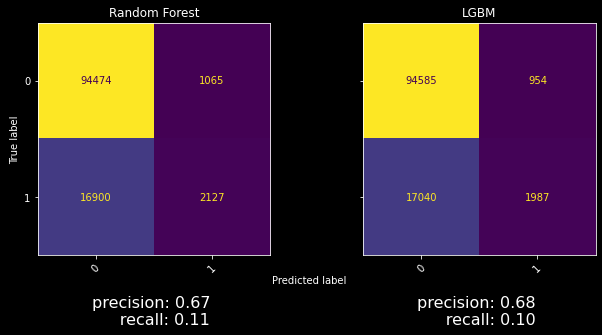

In [264]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 16 artists>

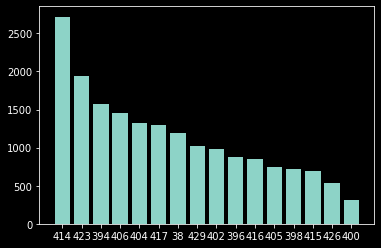

In [186]:
details = pred_details['Random Forest']
data = details[(details['pred'] >= 0.51)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

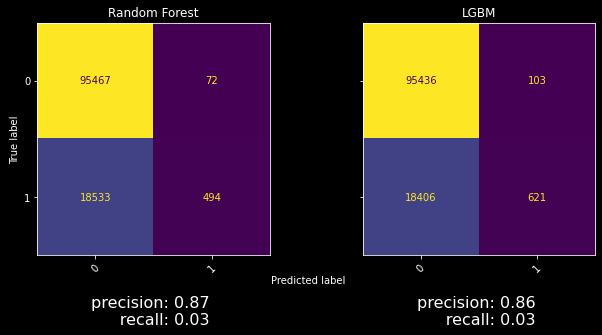

In [265]:
prob = 0.7
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 15 artists>

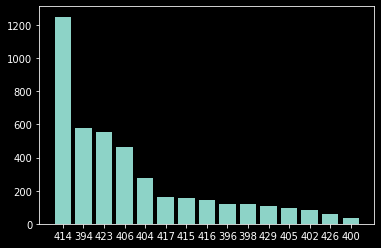

In [225]:
details = pred_details['Random Forest']
data = details[(details['pred'] >= 0.7)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)

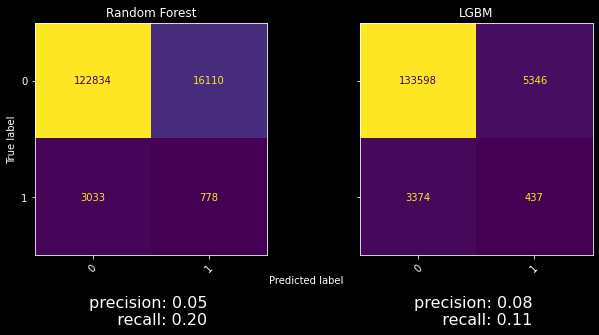

In [266]:
# out subject
out_subj = '38'
y_out = y_AH_dict[out_subj]
feat_out = pd.concat([eog1_dict[out_subj], eog2_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
feat_out = calc_features_after_split(feat_out)

f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

feat_out_data = feat_out.iloc[:, 2:]
feat_out_data = feat_out_data[classifiers['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(feat_out_data)
    cf_matrix = confusion_matrix(y_out, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

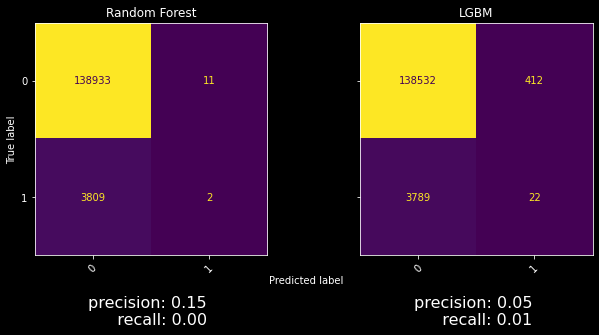

In [267]:
prob = 0.70
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict_proba(feat_out_data).T
    cf_matrix = confusion_matrix(y_out, [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

### split dataset using 12-4 subjects (train-test 75%)

In [229]:
import random
out_subj = random.sample(all_subject, 4)
out_subj

['417', '416', '396', '426']

In [230]:
# EOG 1+2
feat_all_good = pd.DataFrame()
feat_out = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x not in out_subj])
y_out = np.concatenate([y_AH_dict[x] for x in out_subj])

for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    if subj in out_subj:
        feat_out = pd.concat([feat_out, curr_feat])
    else:
        feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)


X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

x_train, x_test, y_train, y_test, prob = X_train_after, X_test_after, y_train, y_test, None
x_train_data = x_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = x_test[x_train_data.columns]

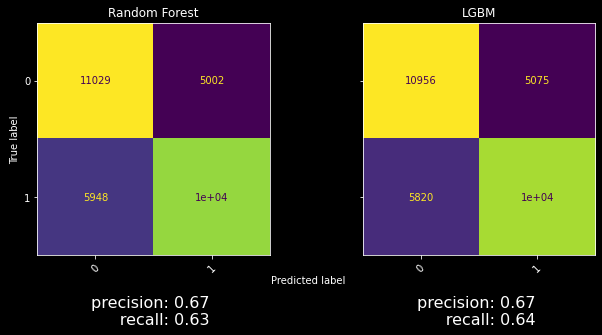

In [231]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

pred_details = {}
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=x_test, copy=True)
    curr_pred_details['pred'] = y_pred
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

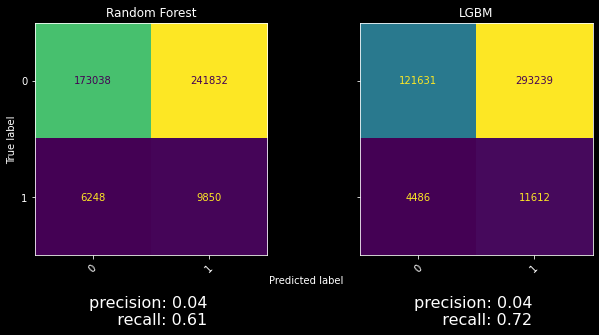

In [232]:
# Add norm values
feat_out = calc_features_after_split(feat_out)
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

feat_out_data = feat_out.iloc[:, 2:]
feat_out_data = feat_out_data[classifiers['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(feat_out_data)
    cf_matrix = confusion_matrix(y_out, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

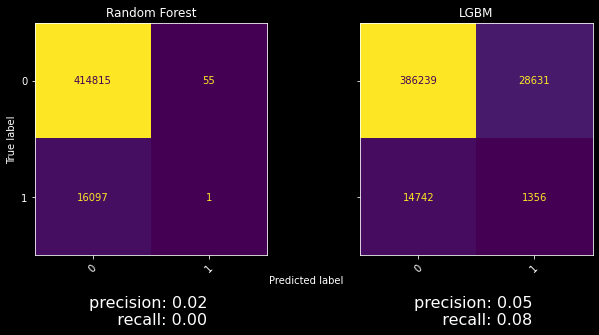

In [233]:
prob = 0.80
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict_proba(feat_out_data).T
    cf_matrix = confusion_matrix(y_out, [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

check out the thing with the features of after norm, seems like worse results

In [5]:
from sklearn.model_selection import RandomizedSearchCV
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=4, verbose=2,
                               random_state=42, n_jobs=-1)

# EOG 1+2
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()) * 5)
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)
x_train_data = X_train_after.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = X_test_after[x_train_data.columns]
# Fit the random search model
rf_random.fit(x_train_data, y_train)
rf_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [11]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    cf_matrix = confusion_matrix(test_labels, predictions)
    metrics = get_metrics(cf_matrix)
    print('Model Performance')
    print('Precision: {:0.4f} '.format(metrics['precision']))
    print('Recall = {:0.2f}%.'.format(metrics['recall']))

    return metrics['precision'], metrics['recall']


base_model = RandomForestClassifier(random_state=42)
base_model.fit(x_train_data, y_train)
base_precision, base_recall = evaluate(base_model, x_test_data, y_test)

best_random = rf_random.best_estimator_
random_precision, random_recall = evaluate(best_random, x_test_data, y_test)

Model Performance
Precision: 0.6664 
Recall = 0.62%.


c:\users\user\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- perm_2_cmin_norm
Feature names seen at fit time, yet now missing:
- af
- af_2

  warnings.warn(message, FutureWarning)


ValueError: X has 65 features, but RandomForestClassifier is expecting 66 features as input.

In [14]:
# EOG 1+2
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)
x_train_data = X_train_after.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = X_test_after[x_train_data.columns]
base_model = RandomForestClassifier(random_state=42)
base_model.fit(x_train_data, y_train)
base_precision, base_recall = evaluate(base_model, x_test_data, y_test)

best_random = rf_random.best_estimator_
random_precision, random_recall = evaluate(best_random, x_test_data, y_test)

Model Performance
Precision: 0.5469 
Recall = 0.12%.
Model Performance
Precision: 0.9237 
Recall = 0.75%.


In [ ]:
# https://www.kaggle.com/code/bitit1994/parameter-grid-search-lgbm-with-scikit-learn/notebook

In [ ]:
# RF grid serach results
{'n_estimators': 1200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [ ]:
# next step of grid search
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': [2, 3],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1100, 1200, 1300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                           cv = 4, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(x_train_data, y_train)
print(grid_search.best_params_)

best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid,  x_test_data, y_test)

# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

### 2023 ###

In [5]:
# EOG 1+2
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject])
for subj in all_subject:
    curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all_good = pd.concat([feat_all_good, curr_feat])

# under sampling non-spikes epochs
feat_all_good['y'] = y_all_good.astype(int)
feat_0 = feat_all_good[feat_all_good['y'] == 0].sample(n=int(y_all_good.sum()))
feat_1 = feat_all_good[feat_all_good['y'] == 1].sample(n=int(y_all_good.sum()))
feat_under = pd.concat([feat_0, feat_1])
y_all_good = feat_under['y'].to_numpy()
feat_all_good = feat_under.drop('y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=feat_all_good['subj'], random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

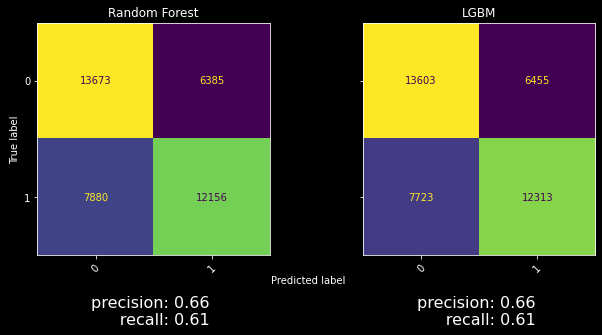

In [6]:
cls, pred_details = plot_results(X_train_after, X_test_after, y_train, y_test)

In [8]:
import datetime
print(datetime.datetime.now())

2023-02-16 12:40:56.015372


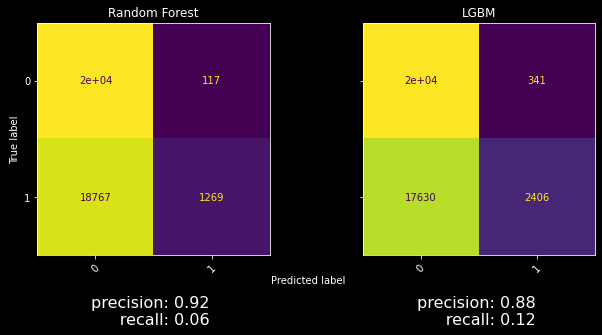

In [12]:
prob = 0.8
x_train_data = X_train_after.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(x_train_data)
x_train_data = x_train_data[x_train_data.columns[selector.get_support(indices=True)]]
x_test_data = X_test_after[x_train_data.columns]
f, axes = plt.subplots(1, len(cls), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(cls.items()):
    if prob is not None:
        y_pred = classifier.predict_proba(x_test_data).T
        cf_matrix = confusion_matrix(y_test, [p > prob for p in y_pred[1]])
    else:
        y_pred = classifier.fit(x_train_data, y_train).predict(x_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                      recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    curr_pred_details = pd.DataFrame(data=X_test_after, copy=True)
    curr_pred_details['pred'] = y_pred[1]
    pred_details[key] = curr_pred_details

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<BarContainer object of 16 artists>

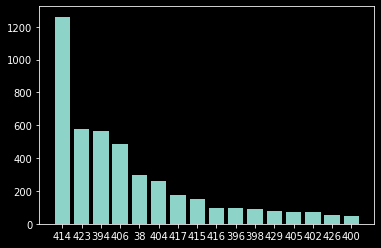

In [13]:
details = pred_details['Random Forest']
data = details[(details['pred'] >= 0.7)].sort_values(by='subj')['subj'].value_counts()
fig, ax = plt.subplots()
ax.bar(data.index, data.values)